<a href="https://colab.research.google.com/github/lab-jianghao/spark_ml_sample/blob/main/09_kmeans_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get install openjdk-17-jdk-headless

!wget https://dlcdn.apache.org/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz /content
!tar xf spark-3.5.0-bin-hadoop3.tgz

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-17-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.0-bin-hadoop3"

In [ ]:
!pip install pyspark==3.5.0

In [4]:
from functools import wraps
from pyspark.sql import SparkSession

def spark_sql_initializer(func):
    @wraps(func)
    def wrapper(*args, **kwargs):

        spark = SparkSession.builder\
            .appName("Colab_SPARK_ML")\
            .master("local[*]")\
            .getOrCreate()

        spark.sparkContext.setLogLevel("WARN")

        func(spark,*args, **kwargs)

        spark.stop()

    return wrapper

In [ ]:
!pip install openml

In [79]:
import openml
import pandas as pd

dataset = openml.datasets.get_dataset(
    466, download_all_files=False, download_data=True, download_qualities=True, download_features_meta_data=True)

versions = dataset.qualities.get('versions')

print("Name:", dataset.name)
print("Description:", dataset.description)
print("Number of features:", dataset.features)
print("Number of instances:", dataset.qualities["NumberOfInstances"])


X, y, _, _ = dataset.get_data(target=dataset.default_target_attribute, dataset_format='dataframe')

print(X.head())


Name: schizo
Description: **Author**:   
**Source**: Unknown - Date unknown  
**Please cite**:   

Schizophrenic Eye-Tracking Data in Rubin and Wu (1997)
Biometrics. Yingnian Wu (wu@hustat.harvard.edu) [14/Oct/97]


Information about the dataset
CLASSTYPE: nominal
CLASSINDEX: last
Number of features: {0: [0 - ID (numeric)], 1: [1 - target (nominal)], 2: [2 - gain_ratio_1 (numeric)], 3: [3 - gain_ratio_2 (numeric)], 4: [4 - gain_ratio_3 (numeric)], 5: [5 - gain_ratio_4 (numeric)], 6: [6 - gain_ratio_5 (numeric)], 7: [7 - gain_ratio_6 (numeric)], 8: [8 - gain_ratio_7 (numeric)], 9: [9 - gain_ratio_8 (numeric)], 10: [10 - gain_ratio_9 (numeric)], 11: [11 - gain_ratio_10 (numeric)], 12: [12 - gain_ratio_11 (numeric)], 13: [13 - sex (nominal)], 14: [14 - class (nominal)]}
Number of instances: 340.0
   ID target  gain_ratio_1  gain_ratio_2  gain_ratio_3  gain_ratio_4  \
0   7     PS         0.935         0.933         0.968         0.920   
1   7     PS         0.909         0.820         0.

In [119]:
import matplotlib.pyplot as plt

def plot_3d_scatter(df, features, prediction_col=None, centers=None):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    df[features] = df[features].astype(float)

    colors = df[prediction_col] if prediction_col else None

    ax.scatter(*[df[feature] for feature in features], s=20, c=colors, marker='o')

    if centers:
        centers_np = np.array(centers)
        ax.scatter(centers_np[:, 0], centers_np[:, 1], centers_np[:, 2], c='red', marker='x', s=200, label='Cluster Centers')

    for idx, feature in enumerate(features):
        ax.set_xlabel(feature) if idx == 0 else ax.set_ylabel(feature) if idx == 1 else ax.set_zlabel(feature)

    plt.show()


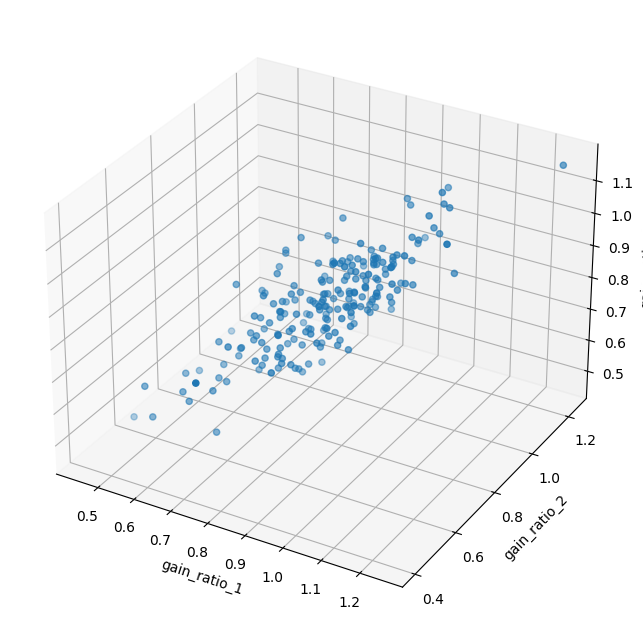

In [124]:
selected_features = ["gain_ratio_1", "gain_ratio_2", "gain_ratio_3"]
plot_3d_scatter(X.copy(), selected_features)

In [122]:
from pyspark.ml import Pipeline

from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.evaluation import ClusteringEvaluator

from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType


@spark_sql_initializer
def train_kmeans(spark, df, k=3):
    schizo_df = spark.createDataFrame(df)
    schizo_df = schizo_df.dropna()
    schizo_df.show()

    feature_columns = ["gain_ratio_1", "gain_ratio_2", "gain_ratio_3"]
    for col_name in feature_columns:
        schizo_df = schizo_df.withColumn(col_name, col(col_name).cast(DoubleType()))


    vector_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

    kmeans = KMeans(featuresCol="features", predictionCol="prediction", k=k)

    kmeans_pipeline = Pipeline(stages=[vector_assembler, kmeans])
    kmeans_model = kmeans_pipeline.fit(schizo_df)

    predictions = kmeans_model.transform(schizo_df)

    evaluator = ClusteringEvaluator()

    silhouette = evaluator.evaluate(predictions)
    print("Silhouette with squared euclidean distance = " + str(silhouette))

    centers = kmeans_model.stages[-1].clusterCenters()
    print("Cluster Centers: ")
    for center in centers:
        print(center)


    plot_3d_scatter(
        predictions.toPandas(),
        features=["gain_ratio_1", "gain_ratio_2", "gain_ratio_3"],
        prediction_col="prediction", centers=centers)


+---+------+------------+------------+------------+------------+------------+------------+------------+------------+------------+-------------+-------------+------+
| ID|target|gain_ratio_1|gain_ratio_2|gain_ratio_3|gain_ratio_4|gain_ratio_5|gain_ratio_6|gain_ratio_7|gain_ratio_8|gain_ratio_9|gain_ratio_10|gain_ratio_11|   sex|
+---+------+------------+------------+------------+------------+------------+------------+------------+------------+------------+-------------+-------------+------+
|  7|    PS|       0.935|       0.933|       0.968|        0.92|       0.993|       0.978|       0.974|       0.871|       0.912|         0.92|        0.883|female|
|  7|    PS|       0.909|        0.82|       0.882|       0.884|       0.813|       0.944|       0.892|       0.882|       0.912|        0.881|        0.879|female|
|  7|    PS|       0.879|       0.864|       0.804|        0.65|        0.74|       0.766|       0.866|       0.817|       0.879|        0.733|        0.845|female|
| 19|    C

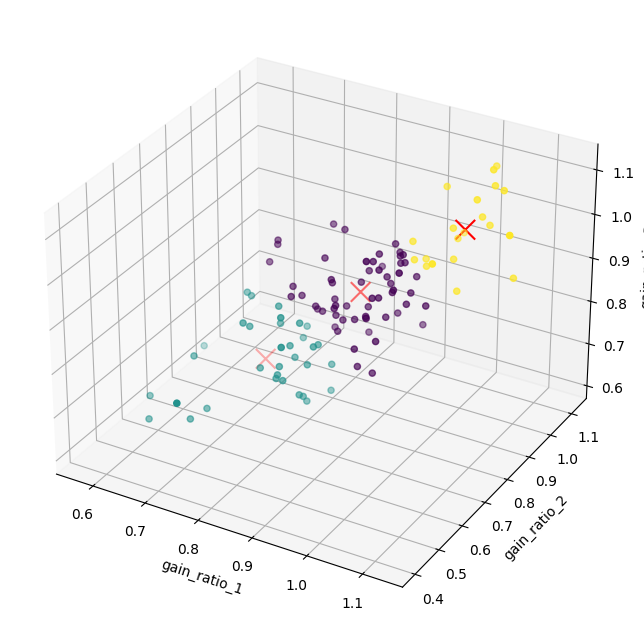

In [123]:
train_kmeans(X.copy())

In [139]:
from pyspark.ml import Pipeline

from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler, OneHotEncoder
from pyspark.ml.evaluation import ClusteringEvaluator

from pyspark.sql.functions import col, count, when, isnan

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


@spark_sql_initializer
def train_G_kmeans(spark, df, k=3):
    schizo_df = spark.createDataFrame(df)
    schizo_df = schizo_df.dropna()
    schizo_df.show()

    target_indexer = StringIndexer(inputCol="target", outputCol="indexed_target")
    sex_indexer = StringIndexer(inputCol="sex", outputCol="indexed_sex")

    schizo_df = target_indexer.fit(schizo_df).transform(schizo_df)
    schizo_df = sex_indexer.fit(schizo_df).transform(schizo_df)

    target_encoder = OneHotEncoder(inputCol="indexed_target", outputCol="encoded_target")
    sex_encoder = OneHotEncoder(inputCol="indexed_sex", outputCol="encoded_sex")

    schizo_df = schizo_df.drop(*['indexed_target', 'indexed_sex'])

    feature_columns = [col for col in schizo_df.columns if col not in ['sex', 'target']]

    for col_name in feature_columns:
        schizo_df = schizo_df.withColumn(col_name, col(col_name).cast(DoubleType()))

    vector_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
    schizo_df = schizo_df.drop(*['encoded_target', 'encoded_sex'])

    kmeans = KMeans(featuresCol="features", predictionCol="prediction", k=k)

    kmeans_pipeline = Pipeline(stages=[target_indexer, sex_indexer, target_encoder, sex_encoder, vector_assembler, kmeans])
    kmeans_model = kmeans_pipeline.fit(schizo_df)

    predictions = kmeans_model.transform(schizo_df)

    evaluator = ClusteringEvaluator()

    silhouette = evaluator.evaluate(predictions)
    print("Silhouette with squared euclidean distance = " + str(silhouette))

    centers = kmeans_model.stages[-1].clusterCenters()
    print("Cluster Centers: ")
    for center in centers:
        print(center)

In [140]:
train_G_kmeans(X.copy())

+---+------+------------+------------+------------+------------+------------+------------+------------+------------+------------+-------------+-------------+------+
| ID|target|gain_ratio_1|gain_ratio_2|gain_ratio_3|gain_ratio_4|gain_ratio_5|gain_ratio_6|gain_ratio_7|gain_ratio_8|gain_ratio_9|gain_ratio_10|gain_ratio_11|   sex|
+---+------+------------+------------+------------+------------+------------+------------+------------+------------+------------+-------------+-------------+------+
|  7|    PS|       0.935|       0.933|       0.968|        0.92|       0.993|       0.978|       0.974|       0.871|       0.912|         0.92|        0.883|female|
|  7|    PS|       0.909|        0.82|       0.882|       0.884|       0.813|       0.944|       0.892|       0.882|       0.912|        0.881|        0.879|female|
|  7|    PS|       0.879|       0.864|       0.804|        0.65|        0.74|       0.766|       0.866|       0.817|       0.879|        0.733|        0.845|female|
| 19|    C

In [153]:
from pyspark.ml import Pipeline

from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import StringIndexer, VectorAssembler, MinMaxScaler, StandardScaler, OneHotEncoder
from pyspark.ml.evaluation import ClusteringEvaluator

from pyspark.sql.functions import col, count, when, isnan

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


@spark_sql_initializer
def train_SG_kmeans(spark, df, k=3):
    schizo_df = spark.createDataFrame(df)
    schizo_df = schizo_df.dropna()
    schizo_df.show()

    target_indexer = StringIndexer(inputCol="target", outputCol="indexed_target")
    sex_indexer = StringIndexer(inputCol="sex", outputCol="indexed_sex")

    schizo_df = target_indexer.fit(schizo_df).transform(schizo_df)
    schizo_df = sex_indexer.fit(schizo_df).transform(schizo_df)

    target_encoder = OneHotEncoder(inputCol="indexed_target", outputCol="encoded_target")
    sex_encoder = OneHotEncoder(inputCol="indexed_sex", outputCol="encoded_sex")

    schizo_df = schizo_df.drop(*['indexed_target', 'indexed_sex'])

    vector_scaler = VectorAssembler(inputCols=["ID"], outputCol="vectored_id")
    schizo_df = vector_scaler.transform(schizo_df)

    id_scaler = MinMaxScaler(inputCol="vectored_id", outputCol="scaled_id")
    schizo_df = id_scaler.fit(schizo_df).transform(schizo_df)
    schizo_df = schizo_df.drop('vectored_id')

    feature_columns = [col for col in schizo_df.columns if col not in ['sex', 'target', 'ID']]

    vector_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
    schizo_df = schizo_df.drop(*['encoded_target', 'encoded_sex', 'scaled_id'])

    kmeans = KMeans(featuresCol="features", predictionCol="prediction", k=k)

    kmeans_pipeline = Pipeline(
        stages=[target_indexer, sex_indexer, target_encoder, sex_encoder, vector_scaler, id_scaler, vector_assembler, kmeans])
    kmeans_model = kmeans_pipeline.fit(schizo_df)

    predictions = kmeans_model.transform(schizo_df)

    evaluator = ClusteringEvaluator()

    silhouette = evaluator.evaluate(predictions)
    print("Silhouette with squared euclidean distance = " + str(silhouette))

    centers = kmeans_model.stages[-1].clusterCenters()
    print("Cluster Centers: ")
    for center in centers:
        print(center)

In [154]:
train_SG_kmeans(X.copy())

+---+------+------------+------------+------------+------------+------------+------------+------------+------------+------------+-------------+-------------+------+
| ID|target|gain_ratio_1|gain_ratio_2|gain_ratio_3|gain_ratio_4|gain_ratio_5|gain_ratio_6|gain_ratio_7|gain_ratio_8|gain_ratio_9|gain_ratio_10|gain_ratio_11|   sex|
+---+------+------------+------------+------------+------------+------------+------------+------------+------------+------------+-------------+-------------+------+
|  7|    PS|       0.935|       0.933|       0.968|        0.92|       0.993|       0.978|       0.974|       0.871|       0.912|         0.92|        0.883|female|
|  7|    PS|       0.909|        0.82|       0.882|       0.884|       0.813|       0.944|       0.892|       0.882|       0.912|        0.881|        0.879|female|
|  7|    PS|       0.879|       0.864|       0.804|        0.65|        0.74|       0.766|       0.866|       0.817|       0.879|        0.733|        0.845|female|
| 19|    C